In [1]:
import os
import sys
sys.path.append('/global/homes/q/qmxp55/DESI/omarlibs')
import raichoorlib
import numpy as np
np.seterr(divide='ignore') # ignode divide by zero warnings
import astropy.io.fits as fits
from astropy.table import Table
from astropy.table import unique
import fitsio
import glob
import healpy as hp
import pymangle
from astropy.coordinates import SkyCoord
import astropy.units as units
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
#from main_def import get_random
print('Libraires loaded')

Libraires loaded


## input files

In [2]:
elgsvdr8 = '/global/cscratch1/sd/raichoor/desits_lss/dr8-0.32.0/lss-dr8-0.32.0-elgsv.data.fits'
dr8randroot = '/global/cscratch1/sd/raichoor/desits_lss/dr8-0.32.0/lss-dr8-0.32.0-elgsv.rand.fits'
dr8pix = '/global/cscratch1/sd/raichoor/desits_lss/dr8-0.32.0/pixweight_ar-dr8-0.32.0-elgsv.fits'
desitile = '/global/cscratch1/sd/raichoor/desi-tiles-viewer.fits' # from Eddie, see [desi-survey 647]

In [60]:
hdu = fits.open(dr8randroot)[1]
print(hdu.columns)

ColDefs(
    name = 'RA'; format = 'D'
    name = 'DEC'; format = 'D'
    name = 'BRICKNAME'; format = '8A'
    name = 'NOBS_G'; format = 'I'
    name = 'NOBS_R'; format = 'I'
    name = 'NOBS_Z'; format = 'I'
    name = 'PSFDEPTH_G'; format = 'E'
    name = 'PSFDEPTH_R'; format = 'E'
    name = 'PSFDEPTH_Z'; format = 'E'
    name = 'GALDEPTH_G'; format = 'E'
    name = 'GALDEPTH_R'; format = 'E'
    name = 'GALDEPTH_Z'; format = 'E'
    name = 'PSFDEPTH_W1'; format = 'E'
    name = 'PSFDEPTH_W2'; format = 'E'
    name = 'PSFSIZE_G'; format = 'E'
    name = 'PSFSIZE_R'; format = 'E'
    name = 'PSFSIZE_Z'; format = 'E'
    name = 'MASKBITS'; format = 'I'
    name = 'EBV'; format = 'E'
    name = 'PHOTSYS'; format = '1A'
    name = 'STARDENS'; format = 'E'
)


## settings

In [74]:
# open pixel catalogue
pixcat = fitsio.read(dr8pix)
#settings
org          = 120  # centre ra for mollweide plots
projection   = 'mollweide'
# for healpy
hdr          = fits.getheader(dr8pix,1)
nside,nest   = hdr['hpxnside'],hdr['hpxnest']
print(hdr['hpxnside'])
npix         = hp.nside2npix(nside)
pixarea      = hp.nside2pixarea(nside,degrees=True)


256


## some functions

In [44]:
def get_isdesi(ra,dec):
    radius   = 1.6 # degree
    tmpnside = 16
    tmpnpix  = hp.nside2npix(tmpnside)
    # first reading desi tiles, inside desi footprint (~14k deg2)
    hdu  = fits.open(desitile)
    data = hdu[1].data
    keep = (data['in_desi']==1)
    data = data[keep]
    tra,tdec = data['ra'],data['dec']
    # get hppix inside desi tiles
    theta,phi  = hp.pix2ang(tmpnside,np.arange(tmpnpix),nest=nest)
    hpra,hpdec = 180./np.pi*phi,90.-180./np.pi*theta
    hpindesi   = np.zeros(tmpnpix,dtype=bool)
    _,ind,_,_,_= raichoorlib.search_around(tra,tdec,hpra,hpdec,search_radius=1.6*3600)
    hpindesi[np.unique(ind)] = True
    ## small hack to recover few rejected pixels inside desi. Avoid holes if any
    tmp  = np.array([i for i in range(tmpnpix) 
                     if hpindesi[hp.get_all_neighbours(tmpnside,i,nest=nest)].sum()==8])
    hpindesi[tmp] = True
    ##
    pixkeep    = np.where(hpindesi)[0]
    # now compute the hppix for the tested positions
    pix  = hp.ang2pix(tmpnside,(90.-dec)*np.pi/180.,ra*np.pi/180.,nest=nest)
    keep = np.in1d(pix,pixkeep)
    return keep

# mollweide plot setting
# http://balbuceosastropy.blogspot.com/2013/09/the-mollweide-projection.html
def set_mwd(ax,org=0):
    # org is the origin of the plot, 0 or a multiple of 30 degrees in [0,360).
    tick_labels = np.array([150, 120, 90, 60, 30, 0, 330, 300, 270, 240, 210])
    tick_labels = np.remainder(tick_labels+360+org,360)
    ax.set_xticklabels(tick_labels)     # we add the scale on the x axis
    ax.set_xlabel('R.A [deg]')
    ax.xaxis.label.set_fontsize(12)
    ax.set_ylabel('Dec. [deg]')
    ax.yaxis.label.set_fontsize(12)
    ax.grid(True)
    return True

# my colormaps
cm = raichoorlib.mycmap(matplotlib.cm.jet, 10,0,1)
cmr= raichoorlib.mycmap(matplotlib.cm.jet_r,10,0,1)

# convert radec for mollwide
def get_radec_mw(ra,dec,org):
    ra          = np.remainder(ra+360-org,360) # shift ra values
    ra[ra>180] -= 360    # scale conversion to [-180, 180]
    ra          =- ra    # reverse the scale: East to the left
    return np.radians(ra),np.radians(dec)

# plot/xlim settings
def get_systplot(systquant):
    tmparray = np.array([
        'stardens',      [2.4,3.7],  r'log10(Stellar density from Gaia/dr2 [deg$^{-2}$])',
        'ebv',           [0.01,0.11],'Galactic extinction ebv [mag]',
        'psfsize_g',     [1,2.6],  'g-band psfsize [arcsec]',
        'psfsize_r',     [1,2.6],  'r-band psfsize [arcsec]',
        'psfsize_z',     [1,2.6],  'z-band psfsize [arcsec]',
        'galdepth_g',    [23.3,25.5],'g-band 5sig. galdepth [mag]',
        'galdepth_r',    [23.1,25],'r-band 5sig. galdepth [mag]',
        'galdepth_z',    [21.6,23.9],'z-band 5sig. galdepth [mag]'],
        dtype='object')
    tmparray = tmparray.reshape(int(tmparray.shape[0]/3),3)
    tmpind   = np.where(tmparray[:,0]==systquant.lower())[0][0]
    return tmparray[tmpind,1], tmparray[tmpind,2]

In [ ]:
# SMC Bootstrap based estimate of the error on the median value
# of a distribution of values
def median_error_boot(y):
    nboot=100 #number of bootstrap samples to average over
    medians=np.zeros(nboot) #initialize array in which the median of each bootstrap smaple will be stored
    for iboot in range(nboot):
        yboot=np.random.choice(y,size=y.size,replace=True)
        medians[iboot]=np.median(yboot) #median of this bootstrap sample
    sigma = np.sqrt(np.var(medians))#sigma of the distribution of medians
    return sigma

In [45]:
maskdir = '/global/cscratch1/sd/pzarrouk/eBOSS-DR16/masks/'

def get_iseboss(data,ra,dec):
    mply = maskdir+'eboss_geometry_eboss0_eboss27.ply'
    mfits = maskdir+'eboss_geometry_eboss0_eboss27.fits'
    comp = maskdir+'eBOSS_QSOgeometry_v5.fits'
    print('> Reading input files')
    m = pymangle.Mangle(mply)
    # Step 1: apply eBOSS geometry per sector
    print('> Getting sector of inputs')
    ids = m.polyid(ra,dec)
    idx = (ids != -1)
    ids = ids[idx]
    data = data[idx]
    #Step 2: Trim the footprint of the catalogues according to completeness
    print('> Finding completeness of sectors')
    sector = Table.read(mfits, format='fits', hdu=1)['SECTOR']
    secs = sector[ids]
    prob = Table.read(comp, format='fits', hdu=1)['SECTOR','COMP_BOSS','SPEC_SUCCESS_RATE']
    prob = unique(prob)
    idx  = np.where(secs.reshape(secs.size,1)==prob['SECTOR'])[1]
    probs = prob['COMP_BOSS'][idx]
    ssr = prob['SPEC_SUCCESS_RATE'][idx]
    data = data[(ssr > 0.5) & (probs > 0.5)]
    return data
    
    
def mask(inl,maskl,data=False):
    keep = np.ones(len(inl),dtype='bool')   #object is outside of veto mask unless it is found       
    for mask in maskl:
        mng = pymangle.Mangle(mask)
        polyid = mng.polyid(inl['RA'],inl['DEC'])
        keep[polyid!=-1] = False #do not keep the object if a polyid is found   
        print(mask+' done, stats are:')
        st = np.sum(keep)
        print(len(inl),st, st/float(len(inl)),(len(inl)-st),(len(inl)-st)/5000.)
    return keep

In [46]:
def plot_sysdens(namesel, syst, mainreg, xlim=None, n=0, nx=20, clip=False, denslims=False, ylab=True):
    hpdens = hpdict[namesel]
    # plot/xlim settings
    if xlim is None:
        xlim, xlabel = get_systplot(syst)
    else:
        _, xlabel = get_systplot(syst)
        
    #do we have inf or nans within syst boundaries
    tmpsyst0 = hpdict[syst]
    mask = (tmpsyst0>xlim[0]) & (tmpsyst0<xlim[1])
    tmpsyst = tmpsyst0[mainreg & mask]
    tmpdens   = hpdens[mainreg & mask]
    #print('%i infs and nans found within %s boundaries (%g, %g)' %(np.sum(~np.isfinite(tmpsyst)), syst, xlim[0], xlim[1]))
    #print('%i infs and nans found in target dens. within %s boundaries (%g, %g)' %(np.sum(~np.isfinite(tmpdens)), syst, xlim[0], xlim[1]))
    
    #xlim = tmpsyst[tmpsyst > 0].min(), tmpsyst[tmpsyst > 0].max()
    if clip: xlim = np.percentile(tmpsyst[tmpsyst>0],(1,99))
    xwidth = (xlim[1]-xlim[0])/nx
        
    # initializing plots
    ax = fig.add_subplot(gs[n])
    ## systematics
    ax.plot(xlim,[1.,1.],color='k',linestyle='--')
    ax.set_xlim(xlim)
    ax.set_ylim(0.8,1.2)
        
    if ylab: ax.set_ylabel(r'n / $\overline{n}$',fontsize=20)
    ax.set_xlabel(xlabel,fontsize=12)
    ax.grid(True)
    title = []
    if clip: title.append('clipped')
    if denslims: title.append('denslims')
    ax.set_title(r'%s %s' %(namesel, ' & '.join(title)))
        
    ## histogram
    axh = ax.twinx()
    axh.set_xlim(xlim)
    axh.set_ylim(0,8)
    axh.axes.get_yaxis().set_ticks([])
    
    ## systematics
    cols = ['0.5','b','r'] #,'r']
    regs = ['all','north','south'] #'des','decals','eboss']
    densmin,densmax = 0,2
    for reg,col in zip(regs,cols):
        if (reg=='all'):
            isreg    = (mainreg)
            lw,alpha = 3,0.5
        else:
            isreg    = (mainreg) & (hpdict[('is'+reg)])
            lw,alpha = 1,1.0
        tmpsyst   = hpdict[syst][isreg]
        #xlim      = tmpsyst[(tmpsyst>0) & (np.isfinite(tmpsyst))].min(), tmpsyst[(tmpsyst>0) & (np.isfinite(tmpsyst))].max()
        #xlim, _ = get_systplot(syst)
        if clip: xlim = np.percentile(tmpsyst[(tmpsyst>0) & (np.isfinite(tmpsyst))],(1,99))
        tmpdens   = hpdens[isreg]
        
        if denslims:
            tmp = ((tmpdens/hpdict['meandens_'+namesel+'_'+reg]>densmin) & 
                     (tmpdens/hpdict['meandens_'+namesel+'_'+reg]<densmax) & 
                     (tmpsyst>xlim[0]) & 
                     (tmpsyst<xlim[1]))
        else:
            tmp       = (tmpsyst>xlim[0]) & (tmpsyst<xlim[1])
            
        systquant = tmpsyst[tmp]
        systdens  = tmpdens[tmp]
        #systdens /= hpdict['meandens_'+namesel+'_'+reg] #density/mean density per bit per region
        systdens /= hpdict['meandens_'+namesel+'_'+'all'] #density/mean density per bit overall desi footprint
        xgrid        = xlim[0]+np.arange(nx+1)/float(nx)*(xlim[1]-xlim[0])
        plotxgrid    = (xgrid[0:-1]+xgrid[1:])/2.
        systnobj     = np.ones(nx)*float('NaN')
        systv        = np.ones(nx)*float('NaN')
        systverr     = np.ones(nx)*float('NaN')
        for j in range(nx):
            tmp      = np.where((systquant >= xgrid[j]) & (systquant < xgrid[j+1]))[0]
            systnobj[j]= len(tmp)
            if (len(tmp) > 0):
            #if ((len(tmp)>0) & (xgrid[j+1]>systmin) & (xgrid[j]<systmax)):
                #print ' ', xgrid[j] , xgrid[j+1], len(systquant[tmp]), np.mean(systdens[tmp])                
                systv[j]   = np.mean(systdens[tmp])
                systverr[j]= np.std(systdens[tmp])/np.sqrt(len(systdens[tmp]))
        tmpl  = 0.05*(xlim[1]-xlim[0])
        tmp = np.isfinite(systv)
        #print syst, t, np.average(systv[tmp],weights=systnobj[tmp]/np.sum(systnobj[tmp]))
        ax.errorbar(plotxgrid,systv,systverr,color=col,ecolor=col,zorder=1,lw=2*lw,alpha=alpha)
        # histogram
        height,_ = np.histogram(systquant,bins=xgrid)
        height   = height.astype(float) / 2.e4
        xcent    = 0.5*(xgrid[1:]+xgrid[:-1])
        if (reg=='all'):
            axh.bar(xcent,height,align='center',width=xwidth,alpha=0.1,color=col)
        axh.step(xcent,height,where='mid',alpha=alpha,lw=lw,color=col)
        

## get mean densities and plot systematics

To plot the target density variation across the systematics a few extra info not available in `dr8pix` file is needed. Such extra info is the `mean target densities` per bit and per region, define the `desi footprint` and `decals footprint` and transform some systematics.

In [30]:
# create new dict with healpix info we need
hpdict = {}

# positions and regions
for key in ['RA', 'DEC', 'ISNORTH', 'ISSOUTH', 'ISDES', 'ELGFRACAREA']:
    hpdict[key.lower()] = pixcat[key]

hpdict['isdesi'] = get_isdesi(hpdict['ra'],hpdict['dec']) 
hpdict['isdecals'] = (hpdict['issouth']) & (~hpdict['isdes'])

# systematics
for key in ['HPXPIXEL', 'FRACAREA', 
            'STARDENS', 'EBV', 
            'PSFDEPTH_G', 'PSFDEPTH_R', 'PSFDEPTH_Z',
            'GALDEPTH_G', 'GALDEPTH_R', 'GALDEPTH_Z',
            'PSFDEPTH_W1', 'PSFDEPTH_W2',
            'PSFSIZE_G', 'PSFSIZE_R', 'PSFSIZE_Z']:
    if (key=='STARDENS'):
        hpdict[key.lower()] = np.log10(pixcat[key])
    elif (key[:8]=='GALDEPTH'):
        hpdict[key.lower()] = 22.5-2.5*np.log10(5./np.sqrt(pixcat[key]))
    else:
        hpdict[key.lower()] = pixcat[key]
        
# elg's hp densities in bits and mean densities
mask = (hpdict['elgfracarea']>0)
for namesel in ['SV', 'BLUE', 'RED']:
    
    hpdict[namesel.lower()] = pixcat[namesel]
    hpdens = hpdict[namesel.lower()]
    
    for reg in ['all','des','decals','north','south']:
        if (reg=='all'):
            hpdict['meandens_'+namesel.lower()+'_'+reg] = np.nanmean(hpdens[mask & (hpdict['isdesi'])])
        else:
            hpdict['meandens_'+namesel.lower()+'_'+reg] = np.nanmean(hpdens[(mask) & (hpdict['isdesi']) & (hpdict[('is'+reg)])])
        print('meandens_'+namesel.lower()+'_'+reg+' = '+'%.0f'%hpdict['meandens_'+namesel.lower()+'_'+reg]+' /deg2')
        

1207 nearby objects
> Reading input files
> Getting sector of inputs
> Finding completeness of sectors
meandens_sv_all = 5257 /deg2
meandens_sv_des = 4733 /deg2
meandens_sv_decals = 5181 /deg2
meandens_sv_north = 5523 /deg2
meandens_sv_south = 5133 /deg2
meandens_sv_eboss = 5458 /deg2
meandens_blue_all = 862 /deg2
meandens_blue_des = 758 /deg2
meandens_blue_decals = 863 /deg2
meandens_blue_north = 883 /deg2
meandens_blue_south = 852 /deg2
meandens_blue_eboss = 757 /deg2
meandens_red_all = 1327 /deg2
meandens_red_des = 1236 /deg2
meandens_red_decals = 1306 /deg2
meandens_red_north = 1387 /deg2
meandens_red_south = 1298 /deg2
meandens_red_eboss = 1664 /deg2


/global/common/software/desi/cori/desiconda/20190804-1.3.0-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:22: RuntimeWarning: invalid value encountered in sqrt


## Clipping

In [ ]:
# dr8_south+north : density distributions + systematics
#print(raichoorlib.get_date(), 'start')

# subsamples (ELG SV supersets)
namesels = ['sv']#, 'blue', 'red']

# settings
isdesi = (hpdict['elgfracarea']>0) & (hpdict['isdesi'])
ramw,decmw = get_radec_mw(hpdict['ra'],hpdict['dec'],org)
systs      = ['stardens','ebv','psfsize_g', 'psfsize_r', 'psfsize_z','galdepth_g', 'galdepth_r', 'galdepth_z']
nx         = 20
densmin,densmax = 0,2
regs       = ['all','north','south']
cols       = ['0.5','b','r'] #,'r']

# looping on subselections
for namesel in namesels:
    
    print('plotting density distributions + systematics for the ', namesel, 'selection')
    
    hpdens = hpdict[namesel]
    hpmean = hpdict['meandens_'+namesel+'_all']
    cmin,cmax = (0.1*hpmean,2*hpmean)
    cbarticks = np.linspace(cmin,cmax,5)
    cbar_ylab = ['%.0f' % x for x in cbarticks]
    clab      = 'dr8/'+namesel+r' density [deg$^{-2}$]'

    # density skymap + hist
    fig        = plt.figure(figsize=(15,5))
    gs         = gridspec.GridSpec(1,2,wspace=0.15,hspace=0.3,width_ratios=[2,1])
    # mollweide
    ax     = plt.subplot(gs[0],projection=projection)
    _      = set_mwd(ax,org=org)
    SC  = ax.scatter(ramw[isdesi],decmw[isdesi],s=1,
        c=hpdens[isdesi],
        cmap=cm,vmin=cmin,vmax=cmax,rasterized=True)
    p  = ax.get_position().get_points().flatten()
    cax= fig.add_axes([p[0]+0.2*(p[2]-p[0]),p[1]+0.2*(p[3]-p[1]),0.3*(p[2]-p[0]),0.025])
    cbar = plt.colorbar(SC, cax=cax, orientation='horizontal', ticklocation='top', extend='both', ticks=cbarticks)
    cbar.set_label(clab,fontweight='bold')
    cbar.ax.set_yticklabels(cbar_ylab)
    # hist
    ax     = plt.subplot(gs[1])
    xgrid  = np.linspace(cmin,cmax,51)
    ax.hist(hpdens[isdesi],
            bins=xgrid,histtype='stepfilled',alpha=0.3,color='k',density=True,
            label='dr8 ('+'%.0f'%hpdict['meandens_'+namesel+'_all']+')')
    for reg,col in zip(regs[1:],cols[1:]):
        tmp = (isdesi) & (hpdict[('is'+reg)])
        ax.hist(hpdens[tmp],
                bins=xgrid,histtype='step',alpha=0.8,color=col,lw=2,density=True,
                label='dr8/'+reg+' ('+'%.0f'%hpdict['meandens_'+namesel+'_'+reg]+')')
    ax.set_xlabel(clab,fontsize=15)
    ax.set_ylabel('norm. counts',fontsize=15)
    ax.set_xlim(cmin,cmax)
    #ax.set_ylim(0,5)
    ax.grid(True)
    ax.legend(ncol=1,loc=2)
    plt.show()
    plt.close()
            
    # systematics
    fig    = plt.figure(figsize=(20,15))
    gs     = gridspec.GridSpec(3,3,hspace=0.30,wspace=0.25)
        
    for i in range(len(systs)+1):
        
        if i == 0:
            axinfo = fig.add_subplot(gs[i])
            # infos
            axinfo.axis('off')
            axinfo.text(0.5,0.9,namesel,fontsize=20,fontweight='bold',ha='center',transform=axinfo.transAxes)
            tmpy = 0.7
            for reg,col in zip(regs,cols):
                tmpstr = reg+' : '+r'$\overline{n}=$'+'%.0f'%hpdict['meandens_'+namesel+'_'+reg]+r' deg$^{-2}$'
                axinfo.text(0.05,tmpy,tmpstr,color=col,fontsize=20,transform=axinfo.transAxes)
                tmpy  -= 0.15
        else:
            syst = systs[i-1]
            if (i%3==0) or (i==1): ylab=True
            else: ylab = False
            plot_sysdens(namesel=namesel, syst=syst, mainreg=isdesi, xlim=None, n=i, nx=nx, clip=True, denslims=False, ylab=ylab)
        
    print('')
    print('')

## No clipping

plotting density distributions + systematics for the  sv selection


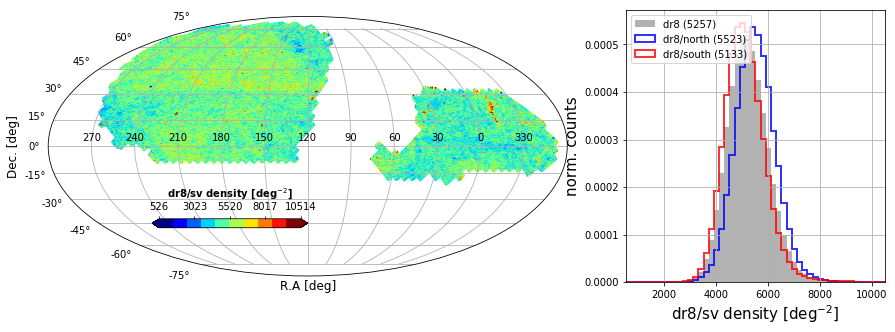

/global/common/software/desi/cori/desiconda/20190804-1.3.0-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:80: RuntimeWarning: invalid value encountered in greater
/global/common/software/desi/cori/desiconda/20190804-1.3.0-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:80: RuntimeWarning: invalid value encountered in less


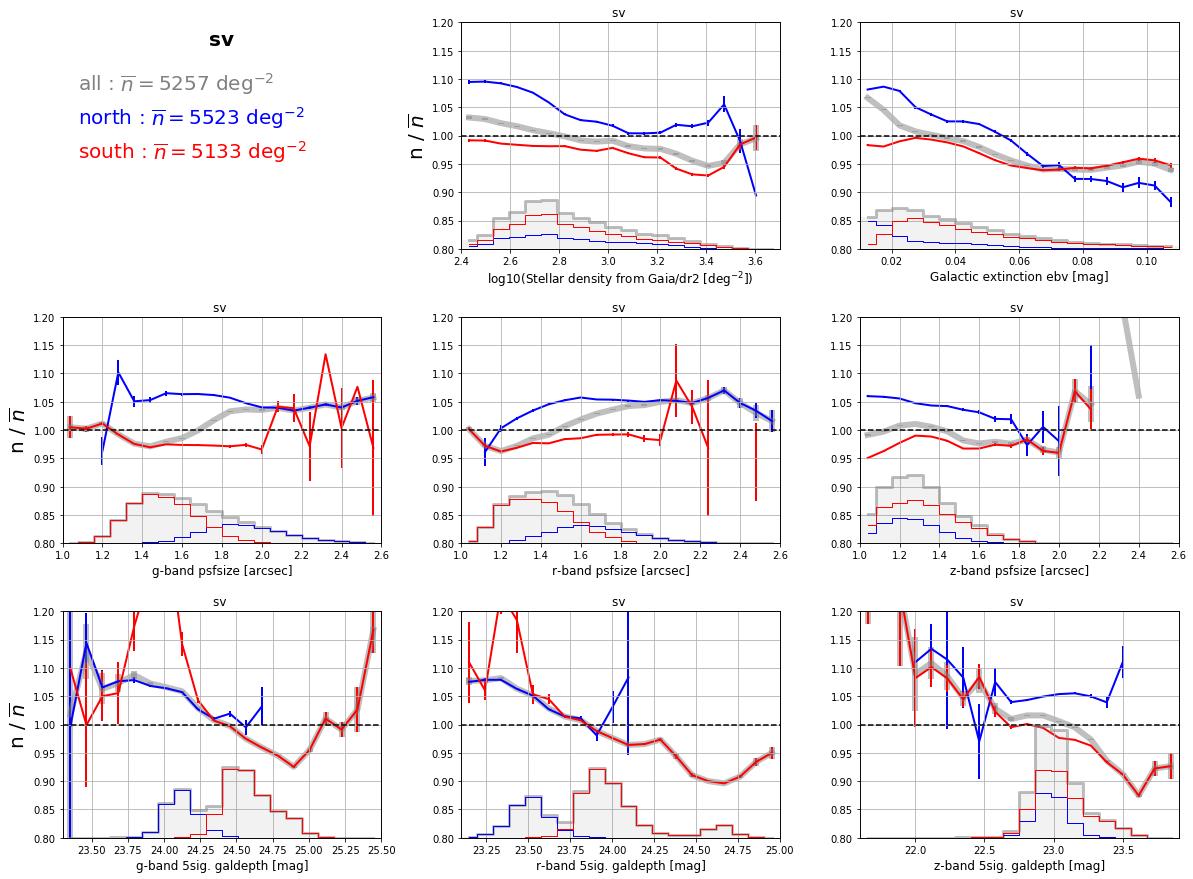

In [39]:
# dr8_south+north : density distributions + systematics
#print(raichoorlib.get_date(), 'start')

# subsamples (ELG SV supersets)
namesels = ['sv']#, 'blue', 'red']

# settings
isdesi = (hpdict['elgfracarea']>0) & (hpdict['isdesi'])
ramw,decmw = get_radec_mw(hpdict['ra'],hpdict['dec'],org)
systs      = ['stardens','ebv','psfsize_g', 'psfsize_r', 'psfsize_z','galdepth_g', 'galdepth_r', 'galdepth_z']
nx         = 20
densmin,densmax = 0,2
regs       = ['all','north','south']
cols       = ['0.5','b','r'] #,'r']

# looping on subselections
for namesel in namesels:
    
    print('plotting density distributions + systematics for the ', namesel, 'selection')
    
    hpdens = hpdict[namesel]
    hpmean = hpdict['meandens_'+namesel+'_all']
    cmin,cmax = (0.1*hpmean,2*hpmean)
    cbarticks = np.linspace(cmin,cmax,5)
    cbar_ylab = ['%.0f' % x for x in cbarticks]
    clab      = 'dr8/'+namesel+r' density [deg$^{-2}$]'

    # density skymap + hist
    fig        = plt.figure(figsize=(15,5))
    gs         = gridspec.GridSpec(1,2,wspace=0.15,hspace=0.3,width_ratios=[2,1])
    # mollweide
    ax     = plt.subplot(gs[0],projection=projection)
    _      = set_mwd(ax,org=org)
    SC  = ax.scatter(ramw[isdesi],decmw[isdesi],s=1,
        c=hpdens[isdesi],
        cmap=cm,vmin=cmin,vmax=cmax,rasterized=True)
    p  = ax.get_position().get_points().flatten()
    cax= fig.add_axes([p[0]+0.2*(p[2]-p[0]),p[1]+0.2*(p[3]-p[1]),0.3*(p[2]-p[0]),0.025])
    cbar = plt.colorbar(SC, cax=cax, orientation='horizontal', ticklocation='top', extend='both', ticks=cbarticks)
    cbar.set_label(clab,fontweight='bold')
    cbar.ax.set_yticklabels(cbar_ylab)
    # hist
    ax     = plt.subplot(gs[1])
    xgrid  = np.linspace(cmin,cmax,51)
    ax.hist(hpdens[isdesi],
            bins=xgrid,histtype='stepfilled',alpha=0.3,color='k',density=True,
            label='dr8 ('+'%.0f'%hpdict['meandens_'+namesel+'_all']+')')
    for reg,col in zip(regs[1:],cols[1:]):
        tmp = (isdesi) & (hpdict[('is'+reg)])
        ax.hist(hpdens[tmp],
                bins=xgrid,histtype='step',alpha=0.8,color=col,lw=2,density=True,
                label='dr8/'+reg+' ('+'%.0f'%hpdict['meandens_'+namesel+'_'+reg]+')')
    ax.set_xlabel(clab,fontsize=15)
    ax.set_ylabel('norm. counts',fontsize=15)
    ax.set_xlim(cmin,cmax)
    #ax.set_ylim(0,5)
    ax.grid(True)
    ax.legend(ncol=1,loc=2)
    plt.show()
    plt.close()
            
    # systematics
    fig    = plt.figure(figsize=(20,15))
    gs     = gridspec.GridSpec(3,3,hspace=0.30,wspace=0.25)
        
    for i in range(len(systs)+1):
        
        if i == 0:
            axinfo = fig.add_subplot(gs[i])
            # infos
            axinfo.axis('off')
            axinfo.text(0.5,0.9,namesel,fontsize=20,fontweight='bold',ha='center',transform=axinfo.transAxes)
            tmpy = 0.7
            for reg,col in zip(regs,cols):
                tmpstr = reg+' : '+r'$\overline{n}=$'+'%.0f'%hpdict['meandens_'+namesel+'_'+reg]+r' deg$^{-2}$'
                axinfo.text(0.05,tmpy,tmpstr,color=col,fontsize=20,transform=axinfo.transAxes)
                tmpy  -= 0.15
        else:
            syst = systs[i-1]
            if (i%3==0) or (i==1): ylab=True
            else: ylab = False
            plot_sysdens(namesel=namesel, syst=syst, mainreg=isdesi, xlim=None, n=i, nx=nx, clip=False, denslims=False, ylab=ylab)
        
    print('')
    print('')

# Calculate photometric weights

1. Import https://github.com/julianbautista/eboss_clustering/. Iminuit is needed, not install in NERSC. To install it on your home, do `pip install --user iminuit`
1. Need to create a sky map of systematics using `mksysmap`. Should be done once only
2. Calculate and store systematic weights into datafile using `do_systematic_weights`

In [10]:
sys.path.append('/global/homes/p/pzarrouk/eboss_clustering-master/python')
import systematic_fitter as sf
from math import *
print('Librairies loaded')

Librairies loaded


In [3]:
def radec2thphi(ra,dec):
    return (-dec+90.)*pi/180.,ra*pi/180.

def get_pix(nside, ra, dec, nest=0):
    return hp.ang2pix(nside, np.radians(-dec+90), np.radians(ra), nest=nest)

In [4]:
mydir = '/global/cscratch1/sd/pzarrouk/desits_lss/'
datoutFile = mydir+'lss-dr8-0.32.0-elgsv-wweight.data.fits'

## Step 0: Cut by eBOSS caps

In [ ]:
def cut_by_cap(data,ngcfile,sgcfile):
    ngc  = (data['ra'] > 90) & (data['ra'] < 270)    
    dr8_ngc = data[ngc]
    fits.writeto(ngcfile,dr8_ngc)

    sgc = (data['ra'] < 70) | (data['ra'] > 290)
    dr8_sgc = data[sgc]   
    fits.writeto(sgcfile,dr8_sgc)
    
    print('Cut by cap done')

## Step 1: Create a skyp map of systematics

In [11]:
def mksysmap(randFile,sysmap,res=512):
    '''
    This should only ever need to be done once.
    Takes big random file with sys quantities and puts them in healpix map
    '''
    npix = 12*res*res
    nrl = np.zeros((npix)) #number of randoms in pixel
    stellar = np.zeros((npix))
    ebv     = np.zeros((npix))
    depth_g = np.zeros((npix))
    depth_r = np.zeros((npix))
    depth_z = np.zeros((npix))
    psf_g   = np.zeros((npix))
    psf_r   = np.zeros((npix))
    psf_z   = np.zeros((npix))
    f = fitsio.read(randFile)
    print(f.size)
    for i in range(0,len(f)):
        th,phi = radec2thphi(f['RA'],f[i]['DEC'])
        pix = hp.ang2pix(res,th,phi)
        nrl[pix] += 1.
        stellar[pix] += f[i]['STARDENS']
        ebv[pix] += f[i]['EBV']
        depth_g[pix] += f[i]['GALDEPTH_G']
        depth_r[pix] += f[i]['GALDEPTH_R']
        depth_z[pix] += f[i]['GALDEPTH_Z']
        psf_g[pix] += f[i]['PSFSIZE_G']
        psf_r[pix] += f[i]['PSFSIZE_R']
        psf_z[pix] += f[i]['PSFSIZE_Z']
        stellar /= nrl
        ebv /= nrl
        depth_g /= nrl
        depth_r /= nrl
        depth_z /= nrl
        psf_g /= nrl
        psf_r /= nrl
        psf_z /= nrl
        to = Table([nrl,stellar,ebv,depth_g,depth_r,depth_z,psf_g,psf_r,psf_z],names=('NRAN','STARDENS','EBV','DEPTH_G','DEPTH_R','DEPTH_Z','PSF_G','PSF_R','PSF_Z'))   
        to.write(mydir+sysmap+'_nside'+str(res)+'.fits', format='fits', overwrite=True)
        return True    

In [66]:
print(raichoorlib.get_date(), 'start')

print('> Make map with properties to test systematics')
mksysmap(dr8randroot,'Legacy-Surveys_desisvelg')

print(raichoorlib.get_date(), 'end')

2019-10-22 11:28:20 start
> Make map with properties to test systematics
277819891


/global/common/software/desi/cori/desiconda/20190804-1.3.0-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:30: RuntimeWarning: invalid value encountered in true_divide
/global/common/software/desi/cori/desiconda/20190804-1.3.0-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:31: RuntimeWarning: invalid value encountered in true_divide
/global/common/software/desi/cori/desiconda/20190804-1.3.0-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:32: RuntimeWarning: invalid value encountered in true_divide
/global/common/software/desi/cori/desiconda/20190804-1.3.0-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:33: RuntimeWarning: invalid value encountered in true_divide
/global/common/software/desi/cori/desiconda/20190804-1.3.0-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:34: RuntimeWarning: invalid value encountered in true_divide
/global/common/software/desi/cori/desiconda/20190804-1.3.0-spec/conda/lib/python3.6/site-packag

2019-10-22 11:29:43 end


## Step 2: Calculate systematics weight

In [13]:
def do_systematic_weights(randFile,datinFile,datoutFile,fitmaps,usemaps,sub=.1,seed=124,export_global=False):   
    #sample is the sample being used, e.g. 'lrg'
    #uses files with imaging properties filled
    #NS is either 'NGC' or 'SGC'
    #ver is the version, e.g., 'test'
    #sys is a string containing the name of the systematic to be tested
    #choices are: 'SKY_G','SKY_R','SKY_I','SKY_Z','AIRMASS','EBV','DEPTH_G','DEPTH_R','DEPTH_I','DEPTH_Z','PSF_G','PSF_R','PSF_I','PSF_Z'
    #sysmin is the minimum value of the systematic to be tested, ~25 is a good value to use for stars
    #sysmax is the maximum value of the systematic to be tested, ~200 is a good value to use for stars
    #res is Nside for the healpix map, default should be 512 for sky,seeing,air and 256 for extinction and stars
    #zmin is the minimum redshift to use, 0.6 is minimum used for lrgs, 0.8 for qsos in DR14
    #zmax is the maximum redshift to used, 1.0 for lrgs and 2.2 for qsos in DR14
    
    ran = Table.read(randFile) #read random file
    print('read randoms from ' + randFile)
    dat = Table.read(datinFile) #read data file
    print('read data from ' + datinFile)
    random_fraction = sub
    np.random.seed(seed)
    #-- Defining RA, DEC and weights
    data_ra, data_dec = dat['RA'], dat['DEC']
    rand_ra, rand_dec = ran['RA'], ran['DEC']
    data_we = np.ones(len(data_ra))
    rand_we = np.ones(len(rand_ra))
    #-- Read systematic values for data and randoms
    data_syst, rand_syst = read_systematic_maps(data_ra, data_dec, rand_ra, rand_dec)     
    
    #-- Create fitter object
    s = sf.Syst(data_we, rand_we)
    fit_maps = fitmaps
    use_maps = usemaps
    
    print('> Add the systematic maps we want')
    for syst_name in use_maps:
        s.add_syst(syst_name, data_syst[syst_name], rand_syst[syst_name])
    s.cut_outliers(p=0., verbose=1) 

    print('> Perform global fit')
    nbins=21
    s.prepare(nbins=nbins)
    s.fit_minuit(fit_maps=fit_maps)
    s.plot_overdensity(pars=[None, s.best_pars], ylim=[0.5, 1.5])#, title=f'{sample_name}: global fit')

    print('> Get weights for global fit')
    data_weightsys_global = 1/s.get_model(s.best_pars, data_syst)
    try:
        print('maximum previously set weight_systot '+str(np.max(dat['WEIGHT_SYSTOT'])))
    except:
        dat['WEIGHT_SYSTOT'] = np.ones(len(dat)) #if column doesn't exist, make it 
    #-- Export global weights
    if export_global:
        dat['WEIGHT_SYSTOT'] = data_weightsys_global
        print('Exporting', datoutFile)
        dat.write(datoutFile, overwrite=True)
    return s.best_pars   
 

def read_systematic_maps(data_ra, data_dec, rand_ra, rand_dec):
   
    #-- Dictionaries containing all different systematic values
    data_syst = {}
    rand_syst = {}

    #-- NHI map
#    nhi_file = mapdir+'/NHI_HPX.fits.gz'
#    nhi_file = 'toto'
#    if os.path.exists(nhi_file):
#        print('Reading maps from ', nhi_file)
#        nhi = Table.read(nhi_file)['NHI'].data
        #-- rotate from galactic to equatorial coordinates
#        R = hp.Rotator(coord=['G', 'C'], inv=True)
#        theta, phi = hp.pix2ang(hp.get_nside(nhi), np.arange(nhi.size))
#        mtheta, mphi = R(theta, phi)
#        nhi_eq = hp.get_interp_val(nhi, mtheta, mphi)
#        data_nhi = nhi_eq[get_pix(hp.get_nside(nhi_eq), data_ra, data_dec)]
#        rand_nhi = nhi_eq[get_pix(hp.get_nside(nhi_eq), rand_ra, rand_dec)]
#        data_syst['log10(NHI)'] = np.log10(data_nhi)
#        rand_syst['log10(NHI)'] = np.log10(rand_nhi)
#    else:
#        print(nhi_file+' not found')

    #-- Legacy Surveys systematics
#    print('Reading maps from ', nhi_file)
    sysmap_file = mydir+'Legacy-Surveys_desisvelg_nside512.fits'

    if os.path.exists(sysmap_file):
        print('Reading maps from ', sysmap_file)
        lss_syst = Table.read(sysmap_file)
        data_pix = get_pix(512, data_ra, data_dec) 
        rand_pix = get_pix(512, rand_ra, rand_dec)
        syst_names = ['STARDENS','EBV','DEPTH_G','DEPTH_R','DEPTH_Z','PSF_G','PSF_R','PSF_Z']

        for syst_name in syst_names:
            data_syst[syst_name] = lss_syst[syst_name][data_pix].data
            rand_syst[syst_name] = lss_syst[syst_name][rand_pix].data
    else:
        print(systmap_file+' not found')
        
    #-- Star density
#    star_file = mapdir+'/allstars17.519.9Healpixall256.dat'
#    if os.path.exists(star_file):
#        print('Reading maps from ', star_file)
#        star_density = np.loadtxt(star_file)
#        data_pix = get_pix(256, data_ra, data_dec, nest=1)
#        rand_pix = get_pix(256, rand_ra, rand_dec, nest=1)
#        data_syst['STAR_DENSITY'] = star_density[data_pix]
#        rand_syst['STAR_DENSITY'] = star_density[rand_pix]
#    else:
#        print(star_file+' not found')

    return data_syst, rand_syst

In [14]:
print(raichoorlib.get_date(), 'start')

#sysmin = 22.4
#sysmax = 23.8
randFile   = '/global/cscratch1/sd/raichoor/desits_lss/dr8-0.32.0/lss-dr8-0.32.0-elgsv.rand.fits'
datinFile  = '/global/cscratch1/sd/raichoor/desits_lss/dr8-0.32.0/lss-dr8-0.32.0-elgsv.data.fits'
datoutFile = '/global/cscratch1/sd/pzarrouk/desits_lss/lss-dr8-0.32.0-elgsv.data-wweight.fits'
usemaps = ['STARDENS','EBV','DEPTH_G','DEPTH_R','DEPTH_Z','PSF_G','PSF_R','PSF_Z']
fitmaps = ['STARDENS', 'EBV', 'DEPTH_G']
do_systematic_weights(randFile,datinFile,datoutFile,fitmaps,usemaps,sub=1.,seed=123,export_global=True)

print(raichoorlib.get_date(), 'end')

2019-10-23 08:34:51 start
read randoms from /global/cscratch1/sd/raichoor/desits_lss/dr8-0.32.0/lss-dr8-0.32.0-elgsv.rand.fits
read data from /global/cscratch1/sd/raichoor/desits_lss/dr8-0.32.0/lss-dr8-0.32.0-elgsv.data.fits
Reading maps from  /global/cscratch1/sd/pzarrouk/desits_lss/Legacy-Surveys_desisvelg_nside512.fits
> Add the systematic maps we want
> Perform global fit


ValueError: operands could not be broadcast together with shapes (22,) (21,) 

In [ ]:
# For eBOSS LRG   
usemaps = ['STAR_DENSITY', 'EBV', 'PSF_I', 'DEPTH_I_MINUS_EBV', 'AIRMASS']             
fitmaps = ['STAR_DENSITY', 'EBV']
#For eBOSS Quasars
usemaps = ['STAR_DENSITY', 'EBV', 'PSF_G', 'SKY_G', 'DEPTH_G_MINUS_EBV', 'AIRMASS']
fitmaps = ['DEPTH_G_MINUS_EBV', 'EBV']